<center>
    <img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800"> 
</center>  

# Yet another math for DS course: домашнее задание 5

**ФИО:** Теплов Вячеслав Сергеевич

**Социальный бонус [1 балл]:** у нас онлайн-магистратура, но это не отменяет движа. Сходите куда-нибудь с однокурсниками и прикрепите фото с этого похода сюда.

__Жёсткий дедлайн:__ 23:59MSK 03.11.2024

## Формат сдачи

Сам ноутбук называйте в формате hw-05-USERNAME.ipynb, где USERNAME — ваши фамилия и имя. Файл надо будет сдать в anytask.

## Задача №1: Снижение размерности с помощью SVD (5 баллов)

В этом задании вам предстоит работать с подмножеством датасета, повествующего о химическом составе воды в некоторых реках (источник датасета здесь: http://data.europa.eu/euodp/en/data/dataset/data_waterbase-rivers-10). Данные лежат в файле `dataset_final`.

Загрузим же его поскорей:

In [2]:
import pickle
index_list, feature_list, data_matrix = pickle.load(open('data/dataset_final', 'rb'))

Несколько слово о том, что это за три сущности:
* `index_list` - список id рек, которые были отобраны для задания (если вам захочется узнать, что именно скрывается за этими ужасными id, расшифровки есть в таблице `Waterbase_rivers_v14_Stations.csv`, которую мы для удобства загрузили на вики)
* `feature_list` - список признаков (они имеют вид `год ПРОБЕЛ показатель`)
* `data_matrix` - собственно данные (строки соответствуют рекам из `index_list`, а столбцы - признакам из `feature_list`)

Ваше первое задание - сделать так, чтобы отрисовка всех объектов в координатах первых двух "скрытых" признаков, полученных с помощью SVD, давала хорошую визуализацию датасета. Изначально к этому будут некоторого рода препятствия; мы ожидаем, что вы их устраните.

Сравните результаты с тем, что получилось бы, если воспользоваться [случайными гауссовскими проекциями](http://scikit-learn.org/stable/modules/random_projection.html). Они вызываются следующими заклинаниями:

```
X = # Your matrix
transformer = random_projection.GaussianRandomProjection(n_components='''how many?''')
X_new = transformer.fit_transform(X)
```

Попробуйте понять, какой физический смысл имеют первые три "скрытых" признака, полученных с помощью SVD.

Какие выводы о данных вы можете сделать из построенной визуализации?

In [3]:
data_matrix.shape

(500, 532)

In [4]:
num_zeroes = (data_matrix == 0.0).sum()
print(f'Количество нулевых элементов: {num_zeroes}')
print(f'Количество ненулевых элементов: {data_matrix.size - num_zeroes}')

Количество нулевых элементов: 234603
Количество ненулевых элементов: 31397


Видно, что матрица разряженная, попробуем использовать усеченное SVD

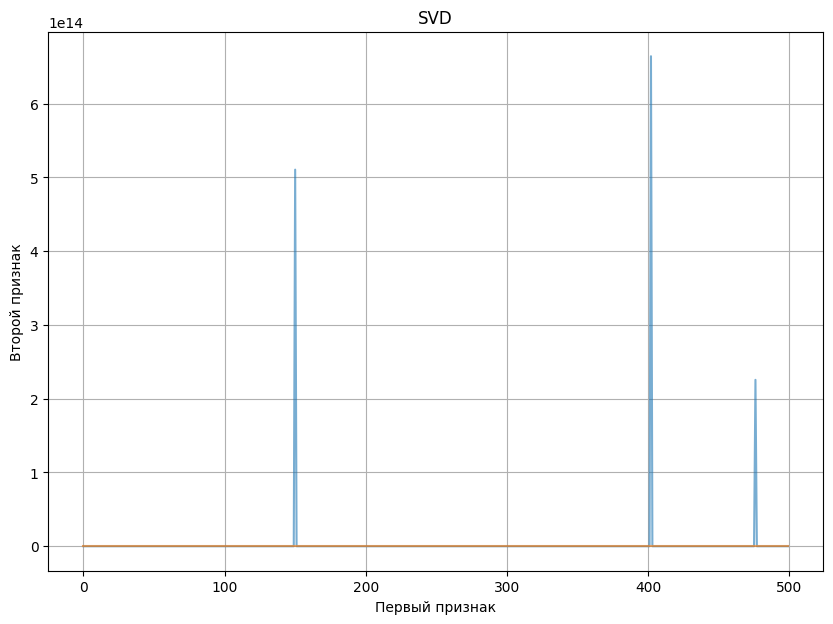

In [5]:
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
data_svd_2d = svd.fit_transform(data_matrix)

plt.figure(figsize=(10, 7))
plt.plot(data_svd_2d, alpha=0.6)
plt.title('SVD')
plt.xlabel('Первый признак')
plt.ylabel('Второй признак')
plt.grid(True)
plt.show()

Судя по графику выше, признаки имеют разные масштабы, попробуем отнормализовать

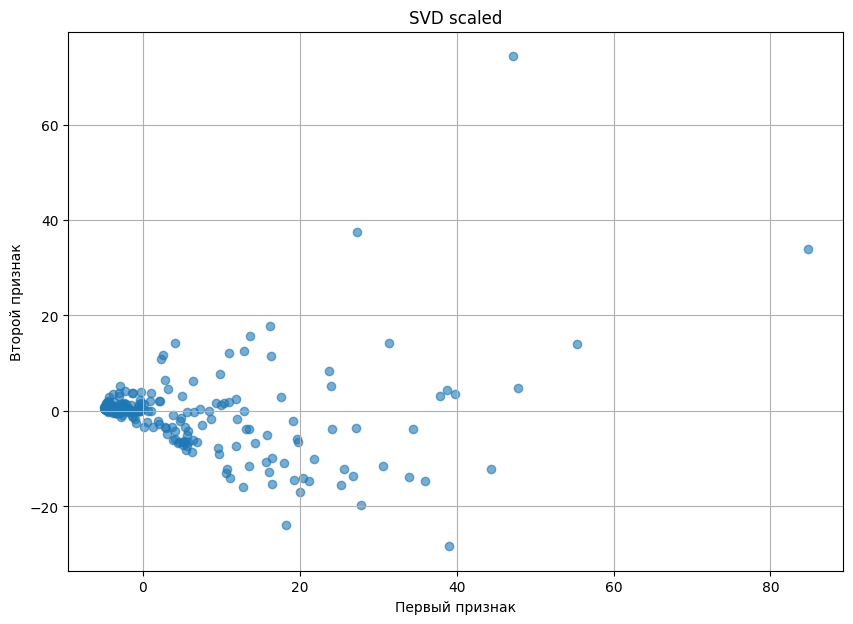

In [9]:
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_matrix)

svd = TruncatedSVD(n_components=2, random_state=42)
svd_transformed = svd.fit_transform(scaled_data)

plt.figure(figsize=(10, 7))
plt.scatter(svd_transformed[:, 0], svd_transformed[:, 1], alpha=0.6)
plt.title('SVD scaled')
plt.xlabel('Первый признак')
plt.ylabel('Второй признак')
plt.grid(True)
plt.show()

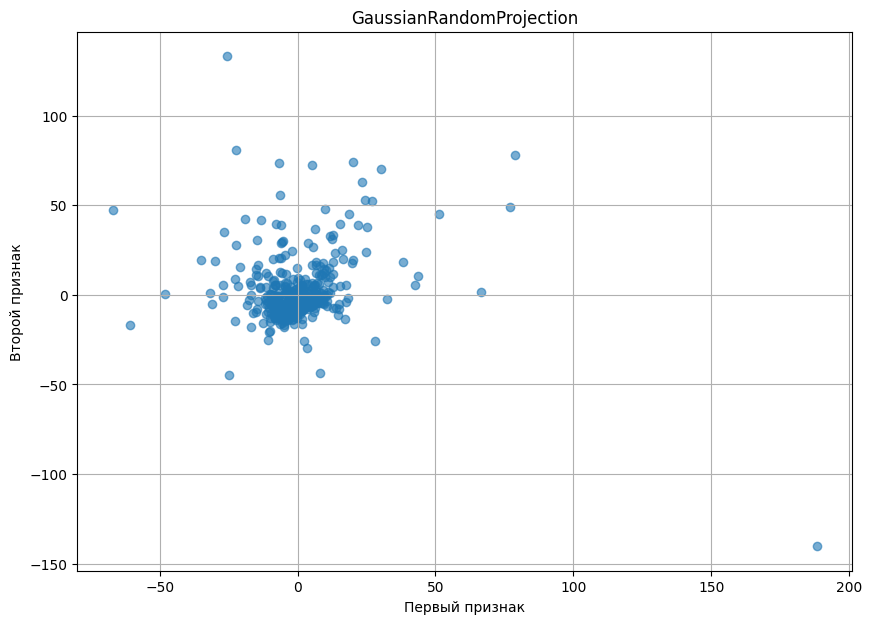

In [10]:
from sklearn import random_projection


transformer = random_projection.GaussianRandomProjection(
    n_components=2, random_state=42)
X_new = transformer.fit_transform(scaled_data)

plt.figure(figsize=(10, 7))
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.6)
plt.title('GaussianRandomProjection')
plt.xlabel('Первый признак')
plt.ylabel('Второй признак')
plt.grid(True)
plt.show()

> __Ответ:__ \
Получается, что SVD понижает размерность, сохраняя макс дисперсию, и на графике можно увидеть кластеры рек с похожими химическими характеристиками. \
Когда как метод случайных проекций  сохраянет общие расстояния между точками, показывая равномерное распределение точек в пространстве пониженной размерности. \ 
Как я понял, в данном случае метод случайных проекций может послужить доказательством того, что рапределение данных после SVD не является случайным, а действительно имеет некую закономерность.


_Комментарий: Эксперименты без выводов, объясняющих полученные результаты, не оцениваются._

## Задача №2: Снижение размерности с помощью SVD (7 баллов)

В компьютерном зрении важную роль играет операция свёртки. Вообще говоря, сворачивать приходится не только матрицы, но и более сложные тензоры, однако в этом задании мы для простоты будем работать только с матрицами.

В этом задании мы будем считать, что индексы элементов в матрицах нумеруются с нуля.

Пусть $B$ - матрица. *Свёртка* матрицы $A$ с ядром (или, как ещё говорят, с фильтром) $B$ - это матрица

$$(A * B)_{ij} = \sum_{p, q}a_{pq}b_{i - p, j - q}$$

Эту загадочную операцию можно проинтерпретировать следующим образом: для каждого элемента матрицы $A$ мы умножаем его "окрестность" (размеры этой окрестности зависят от размеров фильтра) поэлементно на соответствующие коэффициенты из ядра и всё это складываем:

<img src="http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png">

Таким образом, каждый элемент $A$ мы как-то обновляем с учётом его соседей. Скажем, свёртка с ядром

$$B = \frac19\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}$$

будет размывать изображение.

У вас может возникнуть вопрос: а что происходит на краях? Пусть $A$ - матрица $m\times n$, а $B$ - матрица $k\times l$. Есть разные варианты, например, такие:

- можно считать, что "за пределами" $A$ и $B$ тоже есть элементы, но просто они равны нулю; тогда результат свёртки будет иметь размер $(m + k - 1)\times(n + l - 1)$;
- можно точно так же считать, что элементы, лежащие "за пределами" $A$ и $B$ равны нулю, но законными считать только те компоненты свёртки, для которых "центр" фильтра попадает в матрицу $A$, тогда результат свёртки будет иметь такой же размер, как и $A$;
- можно считать законными только те компоненты свёртки, для которых фильтр целиком помещается "внутри" $A$; в этом случае результат свёртки будет меньшего размера, чем исходная матрица, а именно $(m - k + 1)\times(n - l + 1)$.

Дальше мы будем по умолчанию считать, что границы обрабатываются первым из указанных способов.

Свёртка называется *сепарабельной*, если она представляется в виде композиции свёрток

$$A * B = (A * U) * V,$$

где $U$ и $V$ - матрицы $(2t+1)\times1$ и $1\times(2s+1)$ (или $1\times(2s+1)$ и $(2t+1)\times1$).

__[1 балл] Задание 2.1__

Сверните фотографию с фильтром

$$B = \begin{pmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{pmatrix}$$

In [11]:
import cv2 as cv
img = cv.imread("data/chain_small.jpg")
img.shape

(488, 653, 3)

In [12]:
img = img.mean(axis=2) # это матрица из интенсивностей серого цвета; её уже можно подвергать SVD
img.shape

(488, 653)

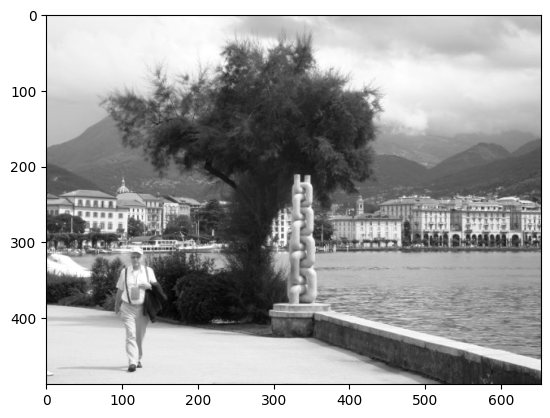

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

imgplot = plt.imshow(img, cmap='gray')

In [20]:
import numpy as np


def conv_equation(A, B):
    m, n = A.shape
    k, l = B.shape

    # Рассчитываем размер паддинга
    pad_h, pad_w = k // 2, l // 2

    # Добавляем паддинг в картинке
    padded_img = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)),
                        mode='constant', constant_values=0)

    result = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            # Рассчитываем значение свёртки для текущего элемента (i, j)
            region = padded_img[i:i + k, j:j + l]
            result[i, j] = np.sum(region * B)

    return result

In [17]:
import numpy as np


B = np.array([[-1, -1, -1],
              [-1, 8, -1],
              [-1, -1, -1]])


conv_img = conv_equation(img, B)

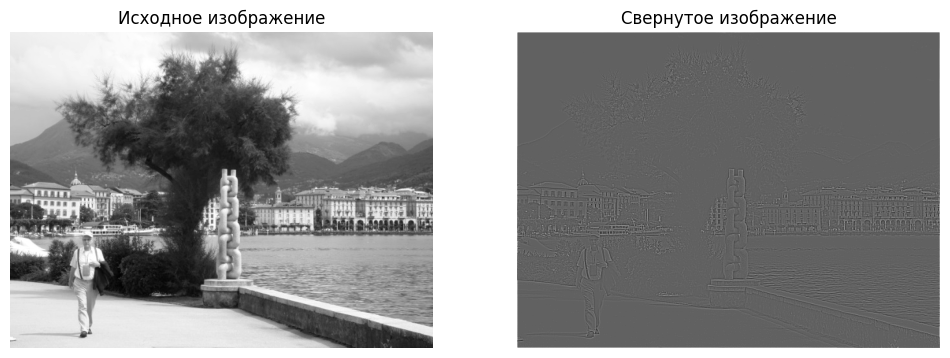

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Исходное изображение')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Свернутое изображение')
plt.imshow(conv_img, cmap='gray')
plt.axis('off')

plt.show()

__[2 балла] Задание 2.2__ Проверьте, что операция свёртки (в которой границы обрабатываются первым из указанных способов!) ассоциативна, то есть 

$$
(A * B) * C = A * (B * C)
$$

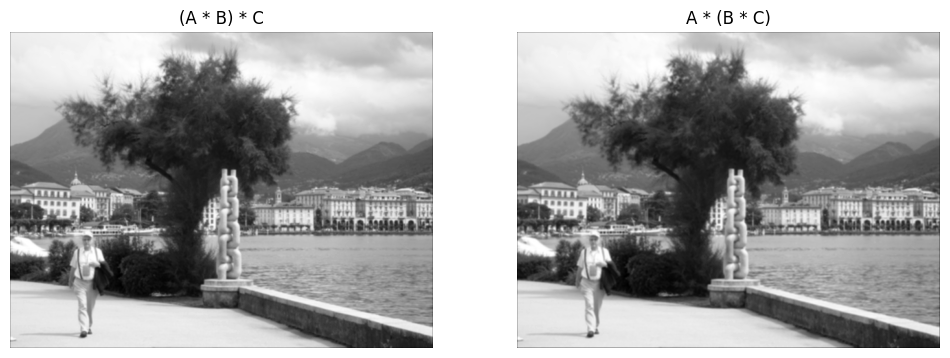

In [24]:
C = np.array([[1, 2, 1],
              [2, 4, 2],
              [1, 2, 1]])


# Рассчитываем (A * B) * C
A_B = conv_equation(img, B)
result_1 = conv_equation(A_B, C)

# Рассчитываем A * (B * C)
B_C = conv_equation(B, C)
result_2 = conv_equation(img, B_C)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('(A * B) * C')
plt.imshow(result_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('A * (B * C)')
plt.imshow(result_2, cmap='gray')
plt.axis('off')

plt.show()

__[2 балла] Задание 2.3__ Убедитесь, что сепарабельную свёртку можно посчитать быстрее, чем не сепарабельную;

Если свёртка не является сепарабельной, нам нужно сделать $$O(h_{img} \cdot w_{img} \cdot h_K \cdot w_K )$$ операций. Если свёртка сепарабельная, её ядро можно представить в виде произведения двух векторов. То есть операция свёртки разбивается на две и осуществляется за $$O(h_{img} \cdot w_{img} \cdot h_K \cdot 1) + O(h_{img} \cdot w_{img} \cdot 1 \cdot w_K)$$ операций. Убедимся в том, что сепарабельная свёртка быстрее с помощью симуляций. 

В качестве сепарабельного ядра возьмём 


$$
K_1 = \frac19 \begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix} = \frac{1}{9} \cdot \begin{pmatrix}
1, 1, 1
\end{pmatrix} \cdot \begin{pmatrix}
1 \\
1 \\
1
\end{pmatrix}
$$

В качестве несепарабельной свёртки возьмём ядро для детектирования границы

$$K_2 = \begin{pmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{pmatrix}$$

In [25]:
import time


K1_h = np.array([1, 1, 1]) / 3
K1_v = np.array([[1], [1], [1]]) / 3

K2 = np.array([[-1, -1, -1],
               [-1, 8, -1],
               [-1, -1, -1]])


def separable_conv(A, horizontal, vertical):
    # Сепарабельная свёртка, сначала горизонтальная, затем вертикальная.
    temp_result = conv_equation(A, horizontal.reshape(1, -1))
    result = conv_equation(temp_result, vertical.reshape(-1, 1))
    return result


# K1
start_time = time.time()
result_K1 = separable_conv(img, K1_h, K1_v)
separable_time = time.time() - start_time

# K2
start_time = time.time()
result_K2 = conv_equation(img, K2)
non_separable_time = time.time() - start_time

separable_time, non_separable_time

(3.460209608078003, 2.01336669921875)

В моем случае сепарабельная свертка оказалась медленее из-за двойного цикла в методе. Попробуем взять готовый библиотечный метод и больший фильтр

In [41]:
from scipy.ndimage import convolve1d, convolve

K1_h_large = np.ones((1, 15)) / 15
K1_v_large = np.ones((15, 1)) / 15

K2_large = np.ones((15, 15)) * -1
K2_large[7, 7] = 224

start_time = time.time()
result_K1_scipy = convolve1d(
    img, K1_h_large.flatten(), axis=1, mode='constant')
result_K1_scipy = convolve1d(
    result_K1_scipy, K1_v_large.flatten(), axis=0, mode='constant')
separable_time_scipy = time.time() - start_time

start_time = time.time()
result_K2_scipy = convolve(img, K2_large, mode='constant')
non_separable_time_scipy = time.time() - start_time

separable_time_scipy, non_separable_time_scipy

(0.007976293563842773, 0.07099795341491699)

Тут уже явно видно, что сепарабельная свертка гораздо быстрее

__[2 балла] Задание 2.4__ Допустим, что вам нужно реализовать операцию свёртки с фильтром $B$, однако приоритетом для вас является скорее скорость, а не абсолютная точность, и поэтому вы готовы ценой не очень большой ошибки заменить исходную свёртку на какую-нибудь сепарабельную. Какую именно векторы $U$ и $V$ вы бы использовали в этом случае? Почему? Попробуйте оценить ошибку.

In [ ]:
# your code here
# (っ˘ڡ˘ς) 